##### Copyright 2018 The TensorFlow Authors.

In [28]:
# Este código fue obtenido del sitio web oficial de TensorFlow y 
# Adaptado por: Jesús Rojas

# Modelo de clasificación de flores en imágenes

Este tutorial muestra como crear y entrenar un modelo de clasificación de imágenes, especificamente flores usando el modelo de `tf.keras.Sequential`. 

El fllujo de trabajo en el tutorial es el siguiente:

1. Examinar y entender el conjunto de datos
2. Construir un `pipeline` de entrada
3. Construir un modelo
4. Entrenar el modelo
5. Testear el modelo
6. Mejor el modelo
7. Exportar el modelo a TensorFlow Lite


## Bibiotecas necesarias


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL #pillow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Creación del conjunto de datos

### Descargar el conjunto de datos

El conjunto de datos contiene 5 clases de flores para clasificar

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [30]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
print(data_dir)

C:\Users\jesus\.keras\datasets\flower_photos_extracted


In [65]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El directorio cuenta con:",image_count, "imágenes")

El directorio cuenta con: 3670 imágenes


Mostramos algunas de las flores que contiene el conjunto de datos

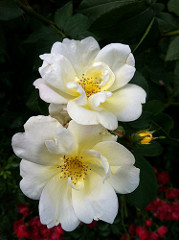

In [66]:
roses = list(data_dir.glob('roses/*')) 
daisy = list(data_dir.glob('daisy/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
dandelion = list(data_dir.glob('dandelion/*'))
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(roses[0]))

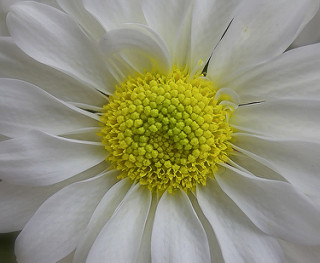

In [67]:
PIL.Image.open(str(daisy[0]))

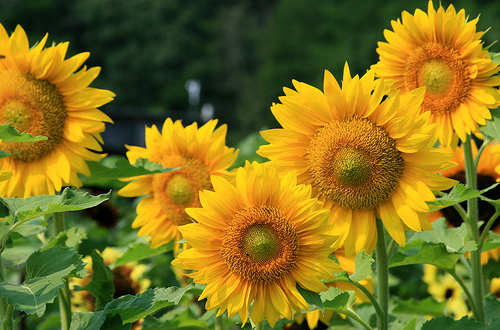

In [68]:
PIL.Image.open(str(sunflowers[0]))

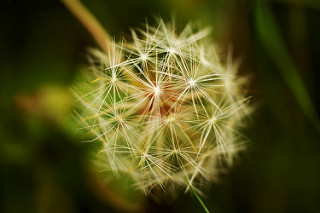

In [69]:
PIL.Image.open(str(dandelion[0]))

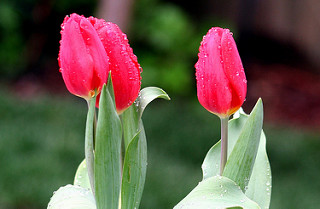

In [70]:
PIL.Image.open(str(tulips[0]))

### Crear el Dataset 

Este bloque de código configura algunos parámetros para cargar imágenes utilizando una utilidad de `Keras`  y establece:

`batch_size`: Es el tamaño de lote, número de imágenes que se procesarán en una sola pasada a través del modelo durante el entrenamiento.

`img_height`: Altura de la imagen.

`img_width`: Ancho de la imagen.

In [71]:
batch_size = 32
img_height = 180
img_width = 180

Es una buena práctica utilizar una división de validación al desarrollar tu modelo. Usa el 80% de las imágenes para el entrenamiento y el 20% para la validación.

In [72]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [73]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [74]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualización de los datos

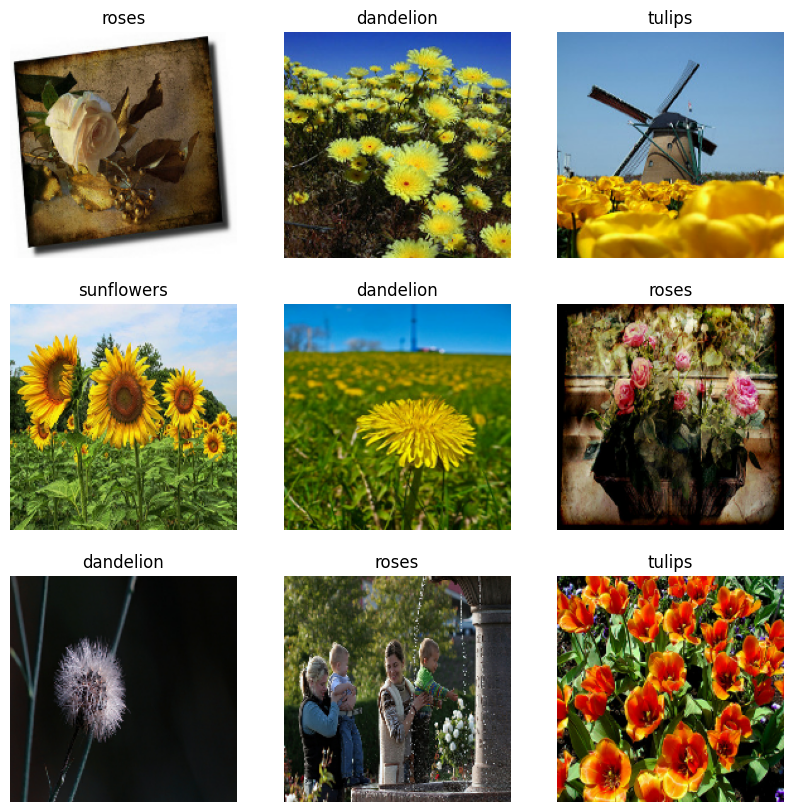

In [75]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [76]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


El `image_batch` es un tensor con la forma (32, 180, 180, 3). Este es un lote de 32 imágenes con forma 180x180x3 (la última dimensión se refiere a los canales de color RGB). El `label_batch` es un tensor con la forma (32,), estas son las etiquetas correspondientes a las 32 imágenes.


### Configurar el conjunto de datos para un mejor rendimiento

Se configura los conjuntos de datos de entrenamiento y validación para mejorar su rendimiento utilizando la caché, el shuffle y el prefetching. Al hacerlo, se optimiza el tiempo de carga de datos y se reduce la posibilidad de que la carga de datos se convierta en un cuello de botella durante el entrenamiento del modelo.

`Dataset.cache` mantiene las imágenes en memoria después de que se cargan del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrenas tu modelo. Si tu conjunto de datos es demasiado grande para caber en memoria, también puedes usar este método para crear una caché eficiente en disco.

`Dataset.prefetch` solapa el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.
Los lectores interesados pueden aprender más sobre ambos métodos, así como sobre cómo almacenar en caché datos en disco, en la sección Prefetching de la guía Mejor rendimiento con la API tf.data.

In [77]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Estandarizar los datos

Convierte los valores de píxeles de las imágenes de un rango de [0, 255] a [0, 1]. Esta normalización es una práctica común en el preprocesamiento de datos para modelos de aprendizaje profundo, ya que puede ayudar a mejorar el rendimiento del modelo durante el entrenamiento.

In [78]:
normalization_layer = layers.Rescaling(1./255)

In [79]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))  # Verificamos que se estandarizó

0.0 0.9867099


## Creación del modelo

### Modelo básico de Keras

El modelo Secuencial de Keras consiste en tres bloques de convolución (`tf.keras.layers.Conv2D`) con una capa de max pooling (`tf.keras.layers.MaxPooling2D`) en cada uno de ellos. Hay una capa completamente conectada (`tf.keras.layers.Dense`) con 128 unidades en la parte superior, que se activa mediante una función de activación ReLU (`'relu'`). Este modelo no ha sido ajustado para lograr una alta precisión; el objetivo de este tutorial es mostrar un enfoque estándar.

In [80]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), 
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\jesus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilar el modelo

Para este tutorial, se escoge el optimizador `tf.keras.optimizers.Adam` y la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy`. Para ver la precisión de entrenamiento y validación en cada época de entrenamiento se pasa el argumento `metrics` a `Model.compile`.

In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Resumen del modelo

Visualiza todas las capas de la red utilizando el método `Model.summary` de Keras:

In [82]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

Entrena el modelo durante 10 épocas utilizando el método `Model.fit` de Keras:

In [83]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step - accuracy: 0.2675 - loss: 1.8243 - val_accuracy: 0.4619 - val_loss: 1.2638
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.5042 - loss: 1.1885 - val_accuracy: 0.5708 - val_loss: 1.0445
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.5858 - loss: 1.0390 - val_accuracy: 0.6253 - val_loss: 0.9644
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.6803 - loss: 0.8259 - val_accuracy: 0.6390 - val_loss: 0.9045
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step - accuracy: 0.7661 - loss: 0.6405 - val_accuracy: 0.6444 - val_loss: 0.9611
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step - accuracy: 0.8534 - loss: 0.4236 - val_accuracy: 0.6540 - val_loss: 1.0261
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 311ms/step - accuracy: 0.9041 - loss: 0.3001 - val_accuracy: 0.6213 - val_loss: 1.2230
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.9507 - loss: 0.1693 - val_accu

### Visualización de los resultados de entrenamiento

Crea gráficos de la pérdida y la precisión en los conjuntos de entrenamiento y validación:

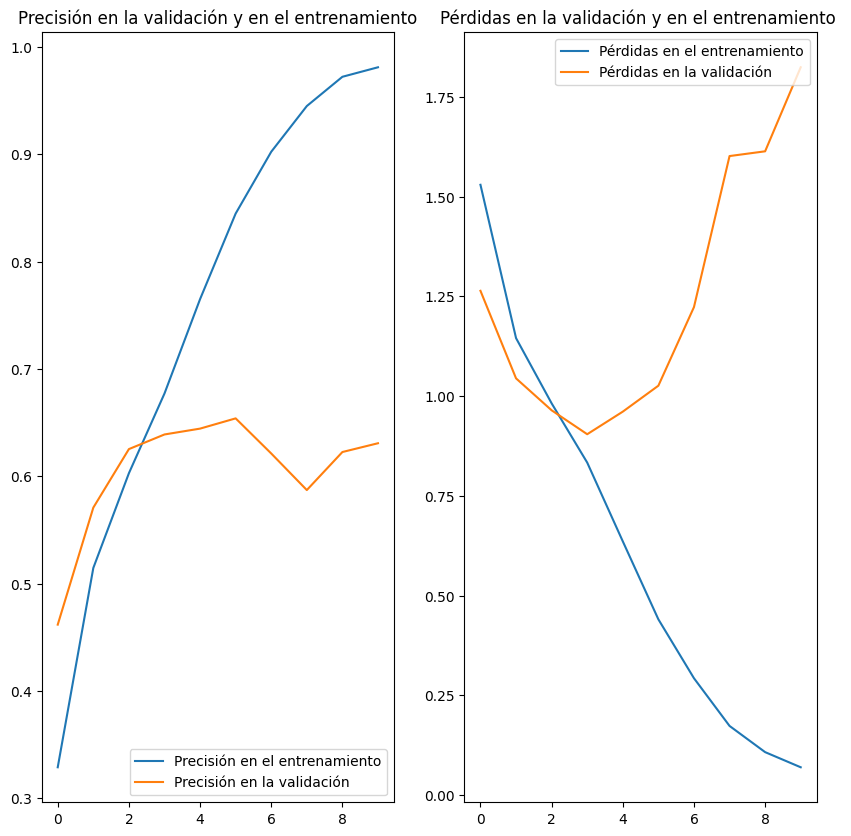

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión en el entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión en la validación')
plt.legend(loc='lower right')
plt.title('Precisión en la validación y en el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdidas en el entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdidas en la validación')
plt.legend(loc='upper right')
plt.title('Pérdidas en la validación y en el entrenamiento ')
plt.show()

Los gráficos muestran que la precisión del entrenamiento y la precisión de validación tienen una gran diferencia, y el modelo ha alcanzado solo alrededor del 60% de precisión en el conjunto de validación.

### Sobreajuste (Overfitting)

En los gráficos anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de validación se detiene alrededor del 60% durante el proceso de entrenamiento. Además, la diferencia en precisión entre el entrenamiento y la validación es notable, lo que es un indicio de sobreajuste

Cuando hay un pequeño número de ejemplos de entrenamiento, el modelo a veces aprende de ruidos o detalles no deseados en los ejemplos de entrenamiento, lo que afecta negativamente el rendimiento del modelo en nuevos ejemplos. Este fenómeno se conoce como sobreajuste. Esto significa que el modelo tendrá dificultades para generalizar con un nuevo conjunto de datos.

Existen múltiples formas de combatir el sobreajuste durante el proceso de entrenamiento. En este tutorial, se utilizará *aumento de datos* y se agregará *dropout* al modelo.

### Aumento de datos (Data augmentation)

El sobreajuste generalmente ocurre cuando hay un pequeño número de ejemplos de entrenamiento. La aumentación de datos adopta el enfoque de generar datos de entrenamiento adicionales a partir de tus ejemplos existentes, aumentándolos mediante transformaciones aleatorias que generan imágenes con apariencia creíble. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

Implementarás la aumentación de datos utilizando las siguientes capas de preprocesamiento de Keras: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` y `tf.keras.layers.RandomZoom`. Estas se pueden incluir dentro de tu modelo como otras capas y se ejecutan en la GPU.

In [85]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualicemos cómo se ven algunos ejemplos aumentados aplicando el aumento de datos a la misma imagen varias veces:

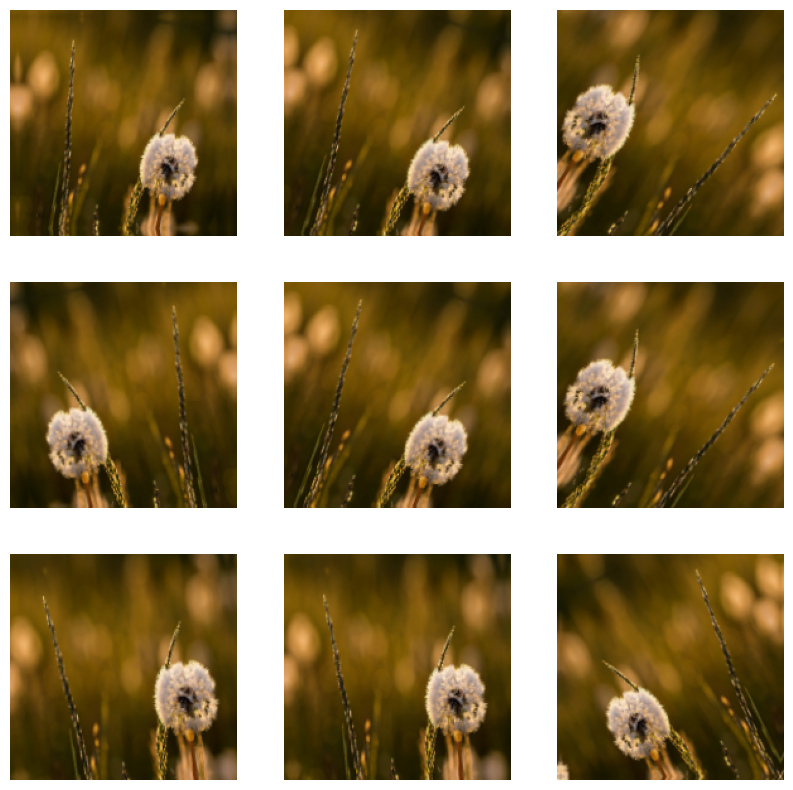

In [86]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[5].numpy().astype("uint8"))
    plt.axis("off")

### Técnica de abandono (Dropout)

Otra técnica para reducir el sobreajuste es introducir la regularización de dropout en la red.

Cuando aplicas dropout a una capa, se eliminan aleatoriamente (estableciendo la activación en cero) una cantidad de unidades de salida de la capa durante el proceso de entrenamiento. Dropout toma un número fraccionario como su valor de entrada, en formas como 0.1, 0.2, 0.4, etc. Esto significa eliminar aleatoriamente el 10%, 20% o 40% de las unidades de salida de la capa aplicada.

Crea una nueva red neuronal con `tf.keras.layers.Dropout` antes de entrenarla utilizando las imágenes aumentadas:

In [87]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compilar y entrenar el modelo 

In [88]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 360ms/step - accuracy: 0.3626 - loss: 1.4958 - val_accuracy: 0.5722 - val_loss: 1.0929
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.5944 - loss: 1.0176 - val_accuracy: 0.6226 - val_loss: 1.0020
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.6235 - loss: 0.9757 - val_accuracy: 0.5995 - val_loss: 1.0089
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.6544 - loss: 0.8854 - val_accuracy: 0.6444 - val_loss: 0.8881
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 340ms/step - accuracy: 0.6745 - loss: 0.8486 - val_accuracy: 0.6376 - val_loss: 0.9848
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 340ms/step - accuracy: 0.7140 - loss: 0.7644 - val_accuracy: 0.6512 - val_loss: 0.8831
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 338ms/step - accuracy: 0.7110 - loss: 0.7262 - val_accuracy: 0.6921 - val_loss: 0.7977
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 337ms/step - accuracy: 0.7420 - loss: 0.7159 - val_accu

### Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

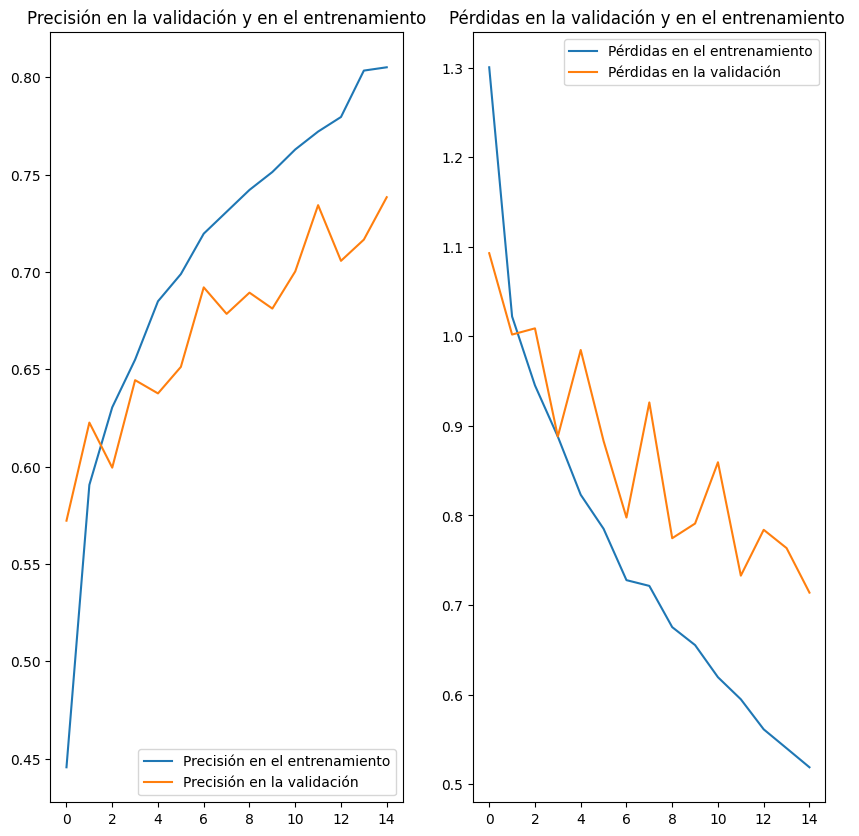

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión en el entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión en la validación')
plt.legend(loc='lower right')
plt.title('Precisión en la validación y en el entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdidas en el entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdidas en la validación')
plt.legend(loc='upper right')
plt.title('Pérdidas en la validación y en el entrenamiento ')
plt.show()

### Pobrar el modelo con nuevos datos

Nota: Para la inferencia el Data augmentation y dropout estan inactivos

In [96]:
flower_url = "https://media.istockphoto.com/id/927047528/vector/sunflower-flower-isolated.jpg?s=612x612&w=0&k=20&c=PO0VpgkzCmtCeke0pjZpOUhmIvAKQ-_IqFcgmt9swMs="
flower_path = tf.keras.utils.get_file('sunflower', origin=flower_url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta flor corresponde a la clase '{}' con una confianza del {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Esta flor corresponde a la clase 'sunflowers' con una confianza del 99.91%.


In [97]:
# Guardar el modelo Keras en el formato .keras
model.save('model.keras')

## TensorFlow Lite

Se va a convertir el modelo de Keras a un modelo de TensorFlow Lite para ayudar a los desarrolladores a ejecutar sus modelos en dispositivos móviles, embebidos y de borde.

En este ejemplo, toma el modelo Keras Sequential entrenado y utiliza `tf.lite.TFLiteConverter.from_keras_model` para generar un modelo TensorFlow Lite

In [98]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jesus\AppData\Local\Temp\tmpibr2wqwg\assets


INFO:tensorflow:Assets written to: C:\Users\jesus\AppData\Local\Temp\tmpibr2wqwg\assets


Saved artifact at 'C:\Users\jesus\AppData\Local\Temp\tmpibr2wqwg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_54')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1245140015952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505238032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505230352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505240336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505235920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505237840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505237264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505236304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1245505240912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1246699472080: TensorSpec(shape=(), dtype=tf.resource, name=None)


El modelo de TensorFlow Lite que guardaste en el paso anterior puede contener varias firmas de función. La API del convertidor de modelos de Keras utiliza automáticamente la firma predeterminada. Aprende más sobre [las firmas de TensorFlow Lite](https://www.tensorflow.org/lite/guide/signatures).

### Ejecutar el modelo de TensorFlow Lite

Puedes acceder a las firmas del modelo guardado de TensorFlow Lite en Python a través de la clase `tf.lite.Interpreter`.

Carga el modelo con el `Interpreter`:

In [99]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Imprime las firmas del modelo convertido para obtener los nombre de los `inputs` y `outputs`. Esto es importante para las predicciones.

In [100]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_54'], 'outputs': ['output_0']}}

En este caso, la firma predeterminada se llama `serving_default`. Además, el nombre de las entradas (`'inputs'`) es `'keras_tensor_54'`, mientras que las salidas (`'outputs'`) se llaman `'outputs_0'`.

Ahora puedes probar el modelo de TensorFlow Lite cargado realizando inferencias sobre una imagen de muestra con `tf.lite.Interpreter.get_signature_runner`, pasando el nombre de la firma de la siguiente manera:

In [103]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Ahora se usará el modelo de TensorFlow Lite para clasificar imágenes que no se incluyeron en los conjuntos de entrenamiento o validación. Similar a como se realizó anteriormente con el modelo de Keras.

Se probará con una imagen de una flor "dandelion".

In [104]:
# Pruebe con distintas imagenes para verificar el funcionamiento 
flower_url_tf="https://www.flowerchimp.com/cdn/shop/articles/dandilieo_1600x.png?v=1680682667"
flower_path_tf = tf.keras.utils.get_file('dandelion2', origin=flower_url_tf)  # NOTA: Cambiar el nombre 'dandelion2' cada vez que se descarga un archivo nuevo

img_tf = tf.keras.utils.load_img(
    flower_path_tf, target_size=(img_height, img_width)
)
img_array_tf = tf.keras.utils.img_to_array(img_tf)
img_array_tf = tf.expand_dims(img_array_tf, 0) # Create a batch

#Predicts with TensorFlow Lite model
predictions_lite = classify_lite(keras_tensor_54=img_array_tf)['output_0'] # NOTA: Importante revisar los nombres de los inputs y outputs
score_lite = tf.nn.softmax(predictions_lite)

print(
    "Esta flor corresponde a la clase '{}' con una confianza del {:.2f}%."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

Esta flor corresponde a la clase 'dandelion' con una confianza del 87.46%.


Las predicciones de ambos modelos deben ser casi iguales:

In [105]:
print(np.max(np.abs(predictions - predictions_lite)))

11.330408


Se imprimen los tamaños de los modelos Keras y TensorFlow Lite para comparación

In [106]:
keras_model_size_bytes = os.path.getsize('model.keras')
keras_model_size_mb = keras_model_size_bytes / (1024 ** 2)
print(f"Tamaño del modelo Keras: {keras_model_size_mb:.2f} MB")

tflite_model_size_bytes = os.path.getsize('model.tflite')
tflite_model_size_mb = tflite_model_size_bytes / (1024 ** 2)
print(f"Tamaño del modelo TensorFlow Lite: {tflite_model_size_mb:.2f} MB")

Tamaño del modelo Keras: 45.71 MB
Tamaño del modelo TensorFlow Lite: 15.22 MB


## Qué sigue?

Visitar el sitio web de TensorFlow Lite para seguir aprendiendo sobre las utilidades de esta herramienta [Tutoriales](https://www.tensorflow.org/lite/tutorials) y [guías](https://www.tensorflow.org/lite/guide).